<h1 style="font-size: 42px; margin-bottom: 2px; line-height: 0px;">AirBnB - Data Story</h1>
<h3 style="line-height: 2px; font-style: italic;"> Timothy Baney<h3>

* <a href="#intro" style="text-decoration: none;">Introduction</a>
* <a href="#import" style="text-decoration: none;">Import Libraries</a>
* <a href="#data-structure" style="text-decoration: none;">Data Structure</a>
    * <a href="#observ-variable" style="text-decoration: none;">Observation Variables</a>
    * <a href="#missing-values" style="text-decoration: none;">Missing Values</a>
    * <a href="#cat-values" style="text-decoration: none;">Categorical Values</a>
* <a href="#problem-nature" style="text-decoration: none;">The Nature of the Problem</a>
    * <a href="#time-series" style="text-decoration: none;">Time Series Analysis</a>
    * <a href="#feature-target" style="text-decoration: none;">Feature/Target Analysis</a>
* <a href="#summary" style="text-decoration: none;">Summary</a> 

## <p id="intro" style="margin-bottom: 0px; line-height: 1px;">Introduction</p>
<p>Founded 8 years ago, and similar to its predecessor CouchSurfing, AirBnb is “an online marketplace and hospitality service, enabling people to lease or rent short-term lodging including vacation rentals, apartment rentals, homestays, hostel beds, or hotel rooms.”. AirBnB is located in San Francisco and currently has over three million listings all over the world. The crux of their problem, and the reason they hosted a competition on Kaggle was in hopes of finding an algorithm that would improve the accuracy of their destination recommendations to first time users. For AirBnB this could have a very positive effect on increasing first time user lodging, and might even improve retention rate for repeat travelers. This notebook is intended to explore the cleansed AirBnB data that I have wrangled to answer questions related to the structure of the data, about what conclusions can be made from the features of the data related to the target. Data structure questions include: what features belong to every observation, how many missing values does each feature own, and for any feature that is of type category, how many values does that categorical data have ? When looking at the nature of the problem, and ways to solve it I will analyze any connections that the data features have with the data target, by using several methods including a time series analysis.</p>

## <p id="import">Import Libraries</p>

In [342]:
import datetime
%matplotlib inline

import pylab
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import datasets, tree
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, RFE
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split

from datetime import datetime as dt

import scipy

import matplotlib.pylab as pylab

ucb_w_reindex = pd.read_csv('clean_airbnb.csv')
ucb = pd.read_csv('clean_airbnb.csv')

full_country_name = {
    'US': 'United States',
    'FR': 'France',
    'DE': 'Denmark',
    'CA': 'Canada',
    'AU': 'Australia',
    'ES': 'Spain',
    'PT': 'Portugal',
    'IT': 'Italy',
    'GB': 'Great Britian',
    'NL': 'Netherlands'
}

pylab.rcParams[ 'figure.figsize' ] = 12 , 5
plt.style.use("fivethirtyeight")

/Users/timothybaney/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## <p id="data-structure">Data Structure</p>

### <p id="observ-variable" style="margin-bottom: 0; line-height: 2px;">Observation Variables</p>
We will first explore how many features exist for each observation. We subtract one to be sure not to include the target variable.

In [312]:
len(ucb.columns) - 1

35

The data has 35 different features, 9 of which being categorical, 12 of which being numerical, and the others being datetimes. 10 of the features are one hot encoding values from the target, and are only meant to assist in analyzing trends over time for each country. These will be removed later.

### <p id="missing-values" style="margin-bottom: 0; line-height: 2px;">Missing Values</p>
How many missing values does each feature have ? Missing values can include things like NaN "Not a number", Null, or even 0 for features such as age, where 0 is impossible. We will drop any one hot encoding boolean values (1 or a 0 for if an observation fits a category or not).

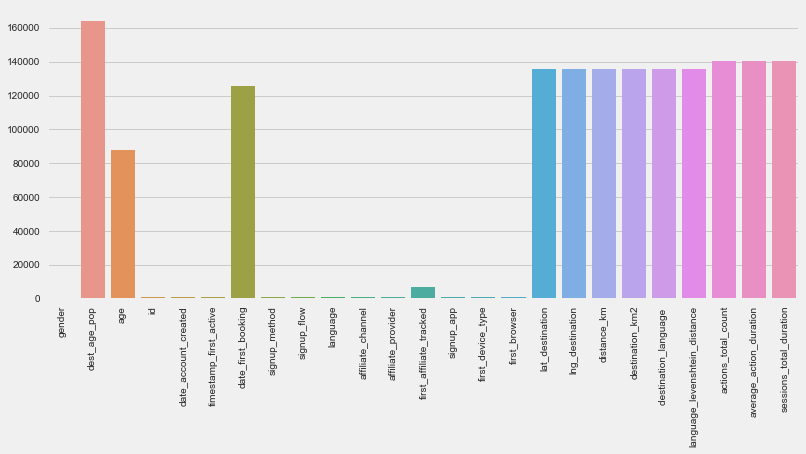

In [313]:
def convertToNull(row):
    if row['age'] == 0:
        return np.nan
    else:
        return row['age']
    
ucb_features = ucb.copy()
ucb_features['age'] = ucb_features.apply(lambda x: convertToNull(x), axis=1)

ucb_features = ucb_features.drop(['country_destination', 'US', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT'], axis=1)

features = ucb_features.columns
feature_nulls = [ucb_features[col].isnull().sum() for col in ucb_features.columns]
fnulls = sns.barplot(features, feature_nulls)
plt.xticks(rotation=90)
plt.show()

There are several missing values for country related features like latitude, longitude, , distance_km2, destination age population, destination_language, and destination_km2. This is because of the target class 'NDF' or 'No Destination found'. This is a user who never booked a trip. This is also a good explanation for why the number of null or missing values for date_first_booking is so high. When merging users and session data, a left join was used in favor of the users dataset which means that any user whose id couldn't be found in a session remained, but received null values for session info. This is why there are so many null values for actions total count, average action durations, and sessions total duration. Unfortunately age, a feature with promising insights has a lot of null values. Any value for age that was zero was considered to be a null value in this case. This simply means that a lot of users don't include their age when signing up.

### <p id="cat-values" style="margin-bottom: 0; line-height: 2px;">Categorical Values</p>
How many unique values does each feature with a type of category have ?

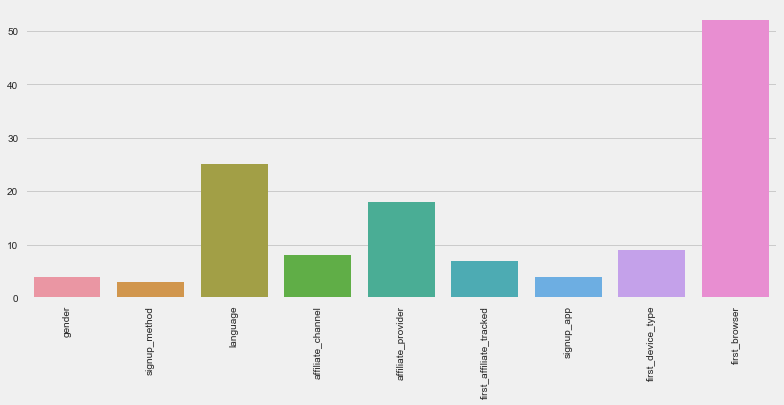

In [314]:
ucb_categories = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

feature_values = [ucb[col].value_counts().count() for col in ucb_categories]
fnulls = sns.barplot(ucb_categories, feature_values)
plt.xticks(rotation=90)
plt.show()

It appears as though most categorical features have less than ten values, the only exceptions being language, affiliate provider, and the first browser used when going to AirBnB.

## <p id="problem-nature">The Nature of the Problem</p>
As mentioned above, this project is related to a Kaggle competition for AirBnB. AirBnB hosted the competition because they were looking for an algorithm that would help them improve their destination recommendations to new users. Based on this, the crux of the issue is to find some connection between a users features like age, gender, and browser to what country their first booking was to. If highly accurate predictions can be made based on this information, it will improve the relevance of AirBnbB's country recommendation. In this section, we will look at feature connections with several differen plot including bar charts, line charts "for time series analysis", and box plots.

### <p id="time-series" style="margin-bottom: 0; line-height: 2px;">Time Series</p>

Over time, is it possible to see any trends between the country destination and other features of the user ? We will explore this by first looking at the total number of visitors to each country over a 4 year time span, in 1 month periods.

In [315]:
ucb_w_reindex['date_account_created'] = pd.to_datetime(ucb['date_account_created'])
ucb_w_reindex = ucb_w_reindex.sort_values('date_account_created', ascending=False)
ucb_w_reindex = ucb_w_reindex.set_index('date_account_created')

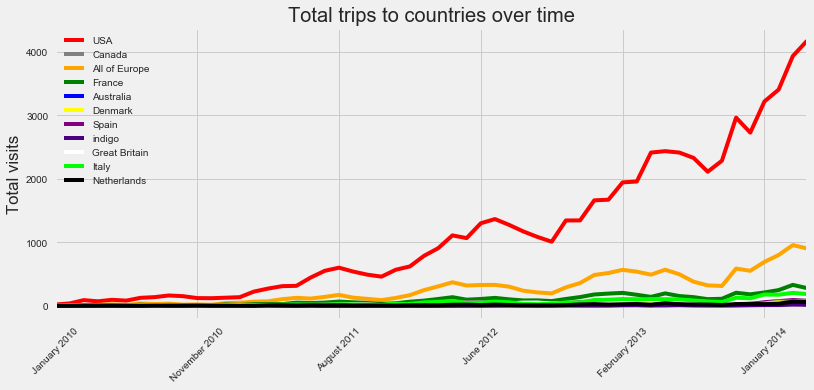

In [316]:
def isEurope(row):
    if row['country_destination'] in ['NL', 'FR', 'DE', 'ES', 'PT', 'GB', 'IT']:
        return 1
    else:
        return 0
    
ucb_w_reindex['eur'] = ucb_w_reindex.apply(lambda x: isEurope(x), axis=1)

labels = ['January 2010', 'November 2010', 'August 2011', 'June 2012', 'February 2013', 'January 2014']

us_m_ot = ucb_w_reindex.US.resample('M').sum()
fr_m_ot = ucb_w_reindex.FR.resample('M').sum()
au_m_ot = ucb_w_reindex.AU.resample('M').sum()
ca_m_ot = ucb_w_reindex.CA.resample('M').sum()
de_m_ot = ucb_w_reindex.DE.resample('M').sum()
es_m_ot = ucb_w_reindex.ES.resample('M').sum()
pt_m_ot = ucb_w_reindex.PT.resample('M').sum()
gb_m_ot = ucb_w_reindex.GB.resample('M').sum()
it_m_ot = ucb_w_reindex.IT.resample('M').sum()
nl_m_ot = ucb_w_reindex.NL.resample('M').sum()

eur_m_ot = ucb_w_reindex.eur.resample('M').sum()

ax = sns.tsplot(data=us_m_ot, color='red', legend=True, condition='USA')
sns.tsplot(data=ca_m_ot, color='gray', legend=True, condition='Canada')
sns.tsplot(data=eur_m_ot, color='orange', legend=True, condition='All of Europe')
sns.tsplot(data=fr_m_ot, color='green', legend=True, condition='France')
sns.tsplot(data=au_m_ot, color='blue', legend=True, condition='Australia')
sns.tsplot(data=de_m_ot, color='yellow', legend=True, condition='Denmark')
sns.tsplot(data=es_m_ot, color='purple', legend=True, condition='Spain')
sns.tsplot(data=pt_m_ot, color='indigo', legend=True, condition='indigo')
sns.tsplot(data=gb_m_ot, color='white', legend=True, condition='Great Britain')
sns.tsplot(data=it_m_ot, color='lime', legend=True, condition='Italy')
sns.tsplot(data=nl_m_ot, color='black', legend=True, condition='Netherlands')

ax.set_xticklabels(labels)

plt.title('Total trips to countries over time')
plt.xticks(rotation=45)
plt.ylabel('Total visits')

plt.legend()
plt.show()

For most European countries, the total number of visitors over a span of 4 years is not rising very much, compared to the number of visitors to the United States where total visitors over that same 4 years is skyrocketing. There are a few explanations for this however. Since the USA is much like Europe in that it is a union of sovereign states, and since most people that visit one country in Europe are likely to visit surrounding ones as well, I grouped all the European countries together as simply ‘Europe’ and plotted its total visitors over time. Even this showed only a modest improvement however.
<br>
<br>
<br>
<br>
Could some connection between the future of major user features like age and gender make a more accurate prediction of where what country the user is most likely to visit ? I wanted to answer this by using more line graphs to show the trend of average age, and average number of males/females for each country over time.

/Users/timothybaney/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: 
.resample() is now a deferred operation
You called rolling(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


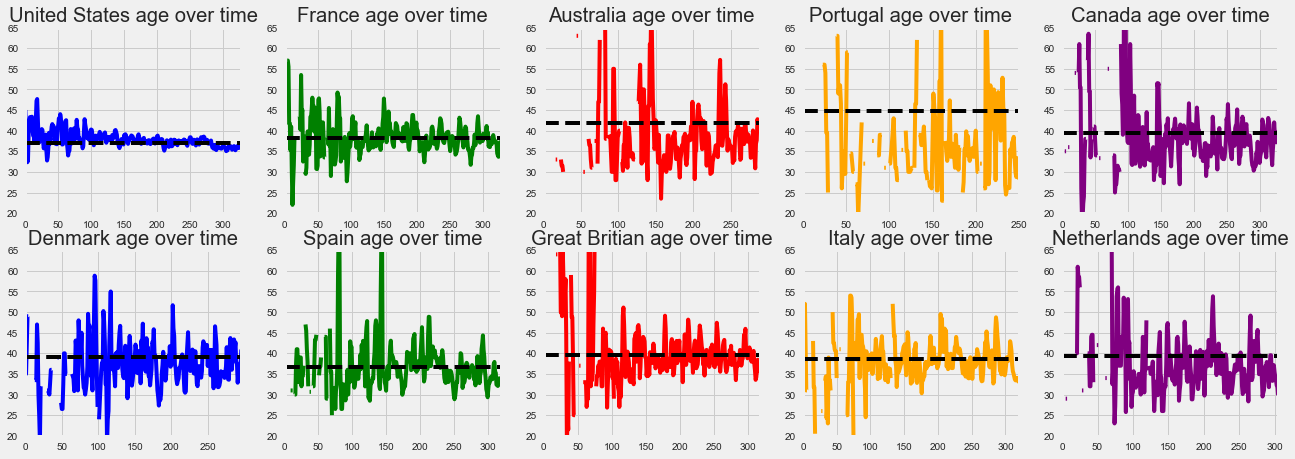

In [317]:
ucb_w_reindex_age = ucb_w_reindex[np.isfinite(ucb_w_reindex['age'])]
ucb_w_reindex_age = ucb_w_reindex_age.loc[ucb_w_reindex_age['age'] < 120]


def ageSeries(country):
    return ucb_w_reindex_age.loc[ucb_w_reindex_age['country_destination'] == country].age.fillna(value=30).resample('5d').rolling(window=3, min_periods=1).mean()

def avgAge(country):
    return ucb_w_reindex_age.loc[ucb_w_reindex_age['country_destination'] == country].age.mean()

num_plots = 10
fig, axes = plt.subplots(2, 5,figsize=(20, 7))

list_of_dfs = [{'country': item, 'age': ageSeries(item), 'avgAge': avgAge(item)} for item in ['US', 'FR', 'AU', 'PT', 'CA', 'DE', 'ES', 'GB', 'IT', 'NL']]

colors = ['blue', 'green', 'red', 'orange', 'purple', 'blue', 'green', 'red', 'orange', 'purple']
col, row, loop = (0, 0, 0)
for obj in list_of_dfs:
    row = math.floor(loop/5)
    
    sns.tsplot(data=obj['age'], color=colors[loop], ax=axes[row, col])
    axes[row, col].set_title('{} age over time'.format(full_country_name[obj['country']]))
    axes[row, col].axhline(obj['avgAge'], color='black', linestyle='dashed', linewidth=4)
    axes[row, col].set(ylim=(20, 65))
        
    col += 1
    loop += 1
    
    if col == 5:
        col = 0
        
plt.show()

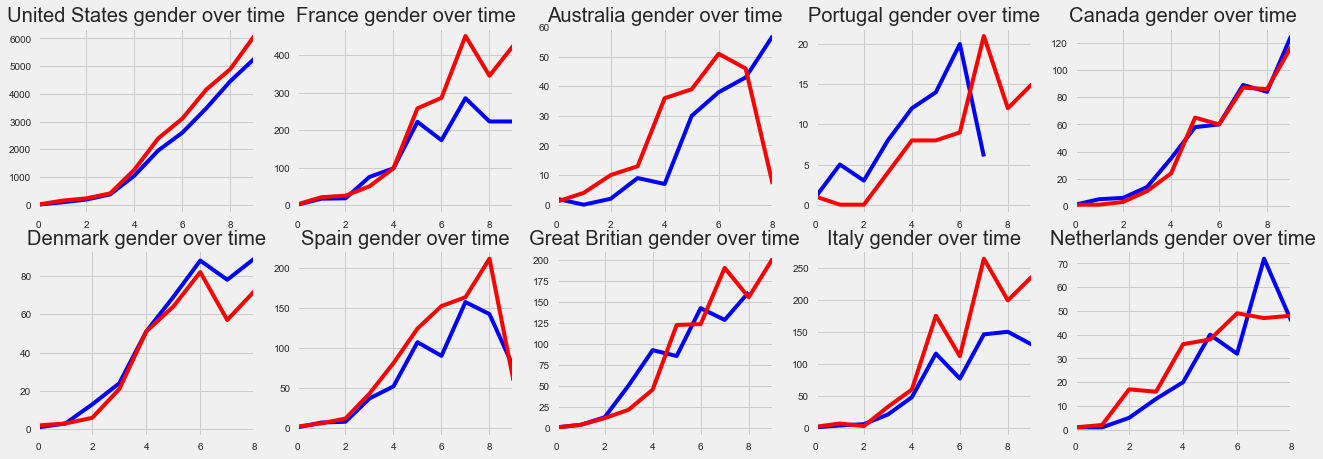

In [318]:
ucb_w_reindex_gender = ucb_w_reindex.copy()

def genderSeries(country, gender):
    return ucb_w_reindex_gender.loc[(ucb_w_reindex_gender['country_destination'] == country) & (ucb_w_reindex_gender['gender'] == gender)]['gender'].fillna(method='ffill').resample('6M').count()

list_of_dfs = [{'country': item, 'dmale': genderSeries(item, 'male'), 'dfem': genderSeries(item, 'female')} for item in ['US', 'FR', 'AU', 'PT', 'CA', 'DE', 'ES', 'GB', 'IT', 'NL']]

num_plots = 10
fig, axes = plt.subplots(2,5,figsize=(20,7))

col, row, loop = (0, 0, 0)
for obj in list_of_dfs:
    row = math.floor(loop/5)
    
    sns.tsplot(data=obj['dmale'], color='blue', ax=axes[row, col])
    sns.tsplot(data=obj['dfem'], color='red', ax=axes[row, col])
    axes[row, col].set_title('{} gender over time'.format(full_country_name[obj['country']]))
        
    col += 1
    loop += 1
    
    if col == 5:
        col = 0

plt.show()

From the time series above, we can make a few conclusions. By looking at the average age per user for each country, we can see that for the United States, and the Netherlands, they are starting to attract younger users, and that the average age in general for visitors to Australia is noteably higher than other countries. In regards to the total number of men vs women booking trips over time for each country, they grow or fall about equally with each other except for Italy, and France, where the the number of males is leveling off, but female visitors continue to grow. Perhaps this is due to Italy and France having a romantic air to its charm that women are attracted to. For Australia, it is just the opposite though as the number of females visiting the country seems to be dropping sharply, whereas the amount of men booking trips there is continuing to grow. Countries in Oceania, like Australia, New Zealand, and Tasmania have more extreme elements to it like living conditions, and extreme sports such as bungee jumping, and rugby that may attract males more than females. 

### <p id="feature-target" style="margin-bottom: 0; line-height: 2px;">Feature/Target Analysis</p>

Lets now look to see if there are any direct connection, or assumptions we can make between features variables, and the country destination chosen.

In [319]:
ucb = ucb.dropna(subset=['date_account_created'])

In [320]:
def getMonth(row, option='create'):
    months = {
        '01': 'January',
        '02': 'February',
        '03': 'March',
        '04': 'April',
        '05': 'May',
        '06': 'June',
        '07': 'July',
        '08': 'August',
        '09': 'September',
        '10': 'October',
        '11': 'November',
        '12': 'December'
    }
    
    if option == 'create':
        if row['date_account_created'] != 'nan':
            month = int(str(row['date_account_created']).split('-')[1])
        else:
            month = np.nan
    else:
        if row['date_first_booking'] != 'nan':
            try:
                month = int(str(row['date_first_booking']).split('-')[1])
            except:
                return
        else:
            month = np.nan
        
    return month
    
ucb['month'] = ucb.apply(lambda x: getMonth(x), axis=1)
ucb['month_booked'] = ucb.apply(lambda x: getMonth(x, 'booking'), axis=1)

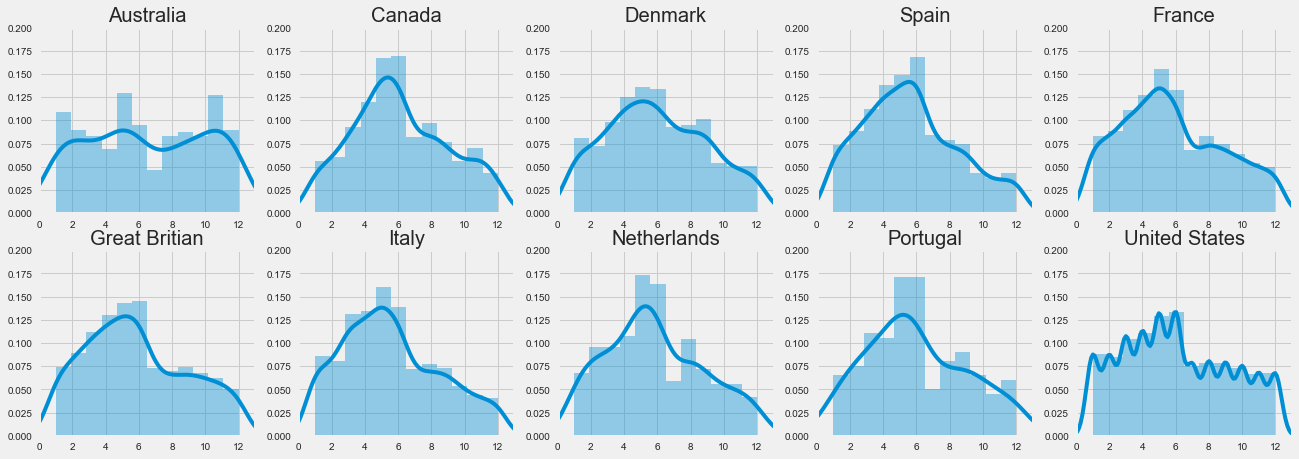

In [321]:
num_plots = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 7))

def buckets(i):
    return [ucb.country_destination.unique()[i]]

col, row, loop = (0, 0, 0)
# iterate through all axes and create a violin plot
for i in range(num_plots):
    row = math.floor(loop/5)

    data = ucb[ucb.country_destination.isin(buckets(i))]
    x = data['month']
    
    objects = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
    y_pos = np.arange(len(objects))
    
    ax_curr = axes[row, col]
    
    title = full_country_name[buckets(i)[0]]
    
    sns.distplot(x, bins=12, ax=ax_curr)
    ax_curr.set_title(title)
    ax_curr.set_ylim([0, .2])
    ax_curr.set_xlim([0, 13])
    ax_curr.set_xlabel('')

#     plt.xticks(y_pos, objects)
    
    col += 1
    loop += 1
    
    if col == 5:
        col = 0

plt.show()

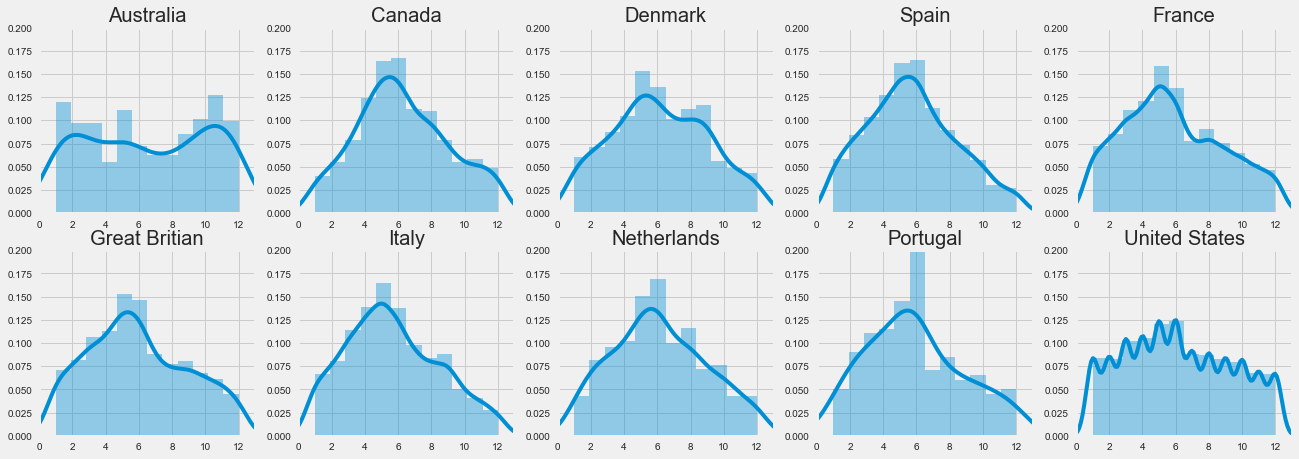

In [322]:
num_plots = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 7))

def buckets(i):
    return [ucb.country_destination.unique()[i]]

col, row, loop = (0, 0, 0)
# iterate through all axes and create a violin plot
for i in range(num_plots):
    row = math.floor(loop/5)

    data = ucb[ucb.country_destination.isin(buckets(i))]
    x = data['month_booked']
    
    objects = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
    y_pos = np.arange(len(objects))
    
    ax_curr = axes[row, col]
    
    title = full_country_name[buckets(i)[0]]
    
    sns.distplot(x, bins=12, ax=ax_curr)
    ax_curr.set_title(title)
    ax_curr.set_ylim([0, .2])
    ax_curr.set_xlim([0, 13])
    ax_curr.set_xlabel('')

#     plt.xticks(y_pos, objects)
    
    col += 1
    loop += 1
    
    if col == 5:
        col = 0

plt.show()

Making a histogram for each month that the user created their account, and for each month that the user booked their first trip, and for each country we can make two clear observations. One is that the time the user books their first trip will typically not be more than 2 months after they create their account. Two being that users are far less likely to book trips anytime in the winter. This can be made clearer by looking at the USA, and Australia. The number of visitors to Australia is more distributed in the months of November through February than any other country. This is most likely due to it being in the southern hemisphere where their seasons are inverted. The USA is very large a geographically located where it enjoys a diverse number of climates (Warm and humid in the south east, warm and dry in the southwest, and cold and dry in the northern Midwest, and cold and humid in the northeast, and northwest), and this may be the reason it has a flatter, more equal distribution compared to other countries farther north, and closer together in Europe.
<br>
<br>
<br>
<br>
Is there some connection between the age, and/or user with the country they visit ?

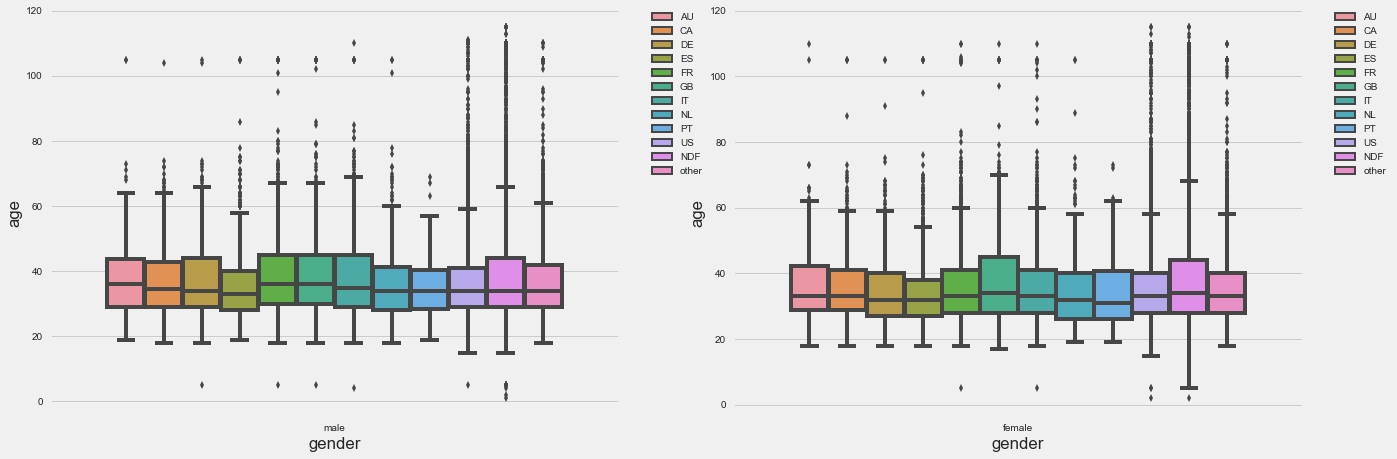

In [328]:
ucb = ucb[np.isfinite(ucb['age'])]
ucb = ucb.loc[(ucb['age'] < 120) & (ucb['age'] > 0)]
ucb = ucb.loc[(ucb['gender'] == 'male') | (ucb['gender'] == 'female')]

# num_plots = 10
fig, axes = plt.subplots(1, 2,figsize=(20, 7))

male_ucb = ucb.loc[ucb['gender'] == 'male']
female_ucb = ucb.loc[ucb['gender'] == 'female']

sns.boxplot(x="gender", y="age", data=male_ucb, hue='country_destination', ax=axes[0])
sns.boxplot(x="gender", y="age", data=female_ucb, hue='country_destination', ax=axes[1])

axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Visualizing age and gender for each country was originally done with violin plots, however the probability density was very hard to discern from other countries so I fell back to simple box and whisker plots. A couple discoveries that were made were that the range between the 1st and second quartiles for Spain was very small, and consisted of the youngest ages for any other country. The range between quartiles for Great Britain was much wider, and for a much older crowd. Younger people will tend to want to ‘go off the unbeaten track’, and find adventure more often than older travelers who may fall into tourist traps more often. Great Britain is a well-known, and more predictable travel destination than Spain, but this is just personal speculation, and more research is needed. 
<br>
<br>
<br>
<br>
There are many different types of internet browsers, and device types in the world today. A lot of them have a specific group of users as well. For instance users of the iOS operating system, and Google Chrome tend to be younger, where as Internet Explorer and Windows operating systems attract an older demographic who is used to them since they have been around for so long. Given this, could there be some link between what browser/device a user uses while on the AirBnB site versus where they will make a trip to ?

IndexError: index 2 is out of bounds for axis 0 with size 2

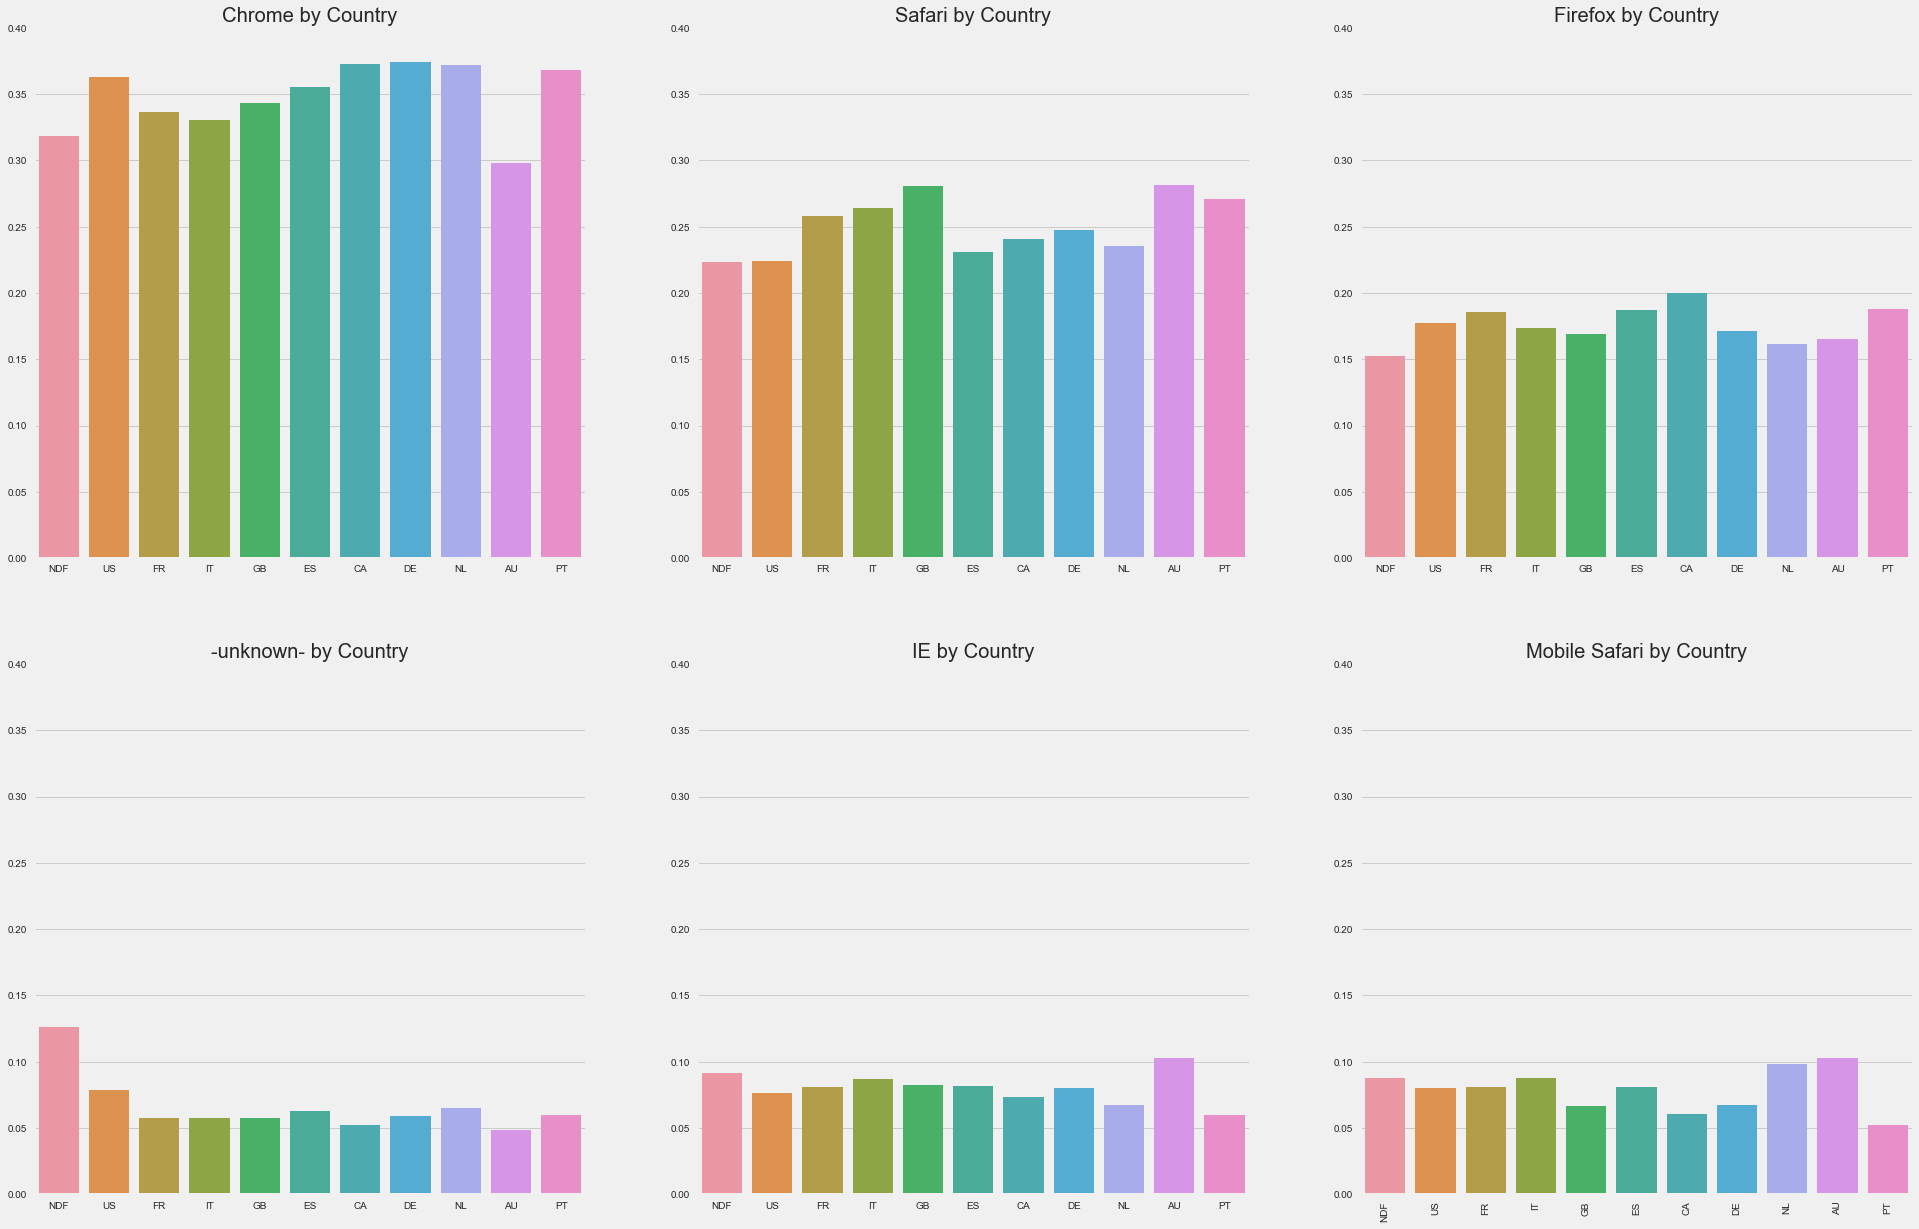

In [333]:
ucb = ucb.loc[ucb['country_destination'] != 'other']

small_browsers = ['AOL Explorer', 'Chromium', 'Silk', 'BlackBerry Browser', 'Apple Mail', 'RockMelt', 'Mobile Firefox', 'Maxthon',
'IceWeasel', 'Camino', 'Sogou Explorer', 'Iron', 'CoolNovo', 'SiteKiosk', 'Pale Moon', 'TheWorld Browser', 'NetNewsWire',
'Mozilla', 'CometBird', 'Opera Mini', 'TenFourFox', 'Stainless', 'IE Mobile', 'Android Browser', 'Chrome Mobile', 'Opera']

for bwsr in small_browsers:
    ucb = ucb.loc[ucb['first_browser'] != bwsr]

fig, axes = plt.subplots(2, 3,figsize=(30, 20))

def totalBrowsersByCountry(country, browser):
    return ucb.loc[(ucb['country_destination'] == country) & (ucb['first_browser'] == browser)]['first_browser'].count() / ucb.loc[ucb['country_destination'] == country]['first_browser'].count() 

ucb_countries = ucb['country_destination'].value_counts().index.tolist()
ucb_browsers = ucb['first_browser'].value_counts().index.tolist()

col, row, loop = (0, 0, 0)
for z in ucb_browsers:
    row = math.floor(loop/3)
    
    ax_curr = axes[row, col]

    country_browser_counts = [totalBrowsersByCountry(x, z) for x in ucb_countries]
    
    bwsr = sns.barplot(ucb_countries, country_browser_counts, ax=ax_curr)
    bwsr.set_title('{} by Country'.format(z))
    ax_curr.set_ylim([0, .4])
    plt.xticks(rotation=90)
    
    col += 1
    loop += 1
    
    if col == 3:
        col = 0

plt.show()

Since there were so many visitors going to the USA, it was hard to see any strong differences between Australia, Canada, and European countries in the list of browser types. For this reason, I used the percentage of people who used the browser going to any country compared to just the total number of users who went with a certain browser. It looks as if Chrome users are more favorable of Canada, the Netherlands, and Denmark, and least likely to go to Australia. Safari users are more likely to go to Great Britain, or Australia, and least likely to visit Spain. It is hard to find any practically significant reason for this. 
<br>
<br>
<br>
<br>
When signing up for an account, AirBnB will ask you for a language preference. Could the percentage of users who go to countries whose native language matches their language preference be considerable ?

/Users/timothybaney/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


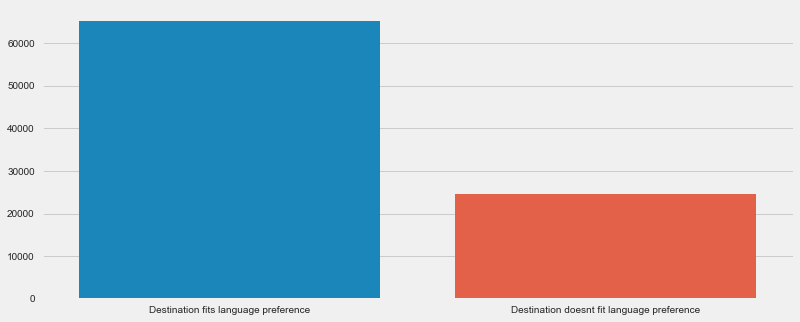

0.72606110542021107

In [334]:
ucb = pd.read_csv('clean_airbnb.csv')
ucb = ucb.loc[ucb['country_destination'] != 'NDF']

lang_dict = {'en': 'eng', 'fr': 'fra', 'it': 'ita', 'es': 'spa', 'de': 'deu', 'nl': 'nld', 'pt': 'por'}

def convertLang(row):
    if row['language'] in lang_dict:
        return lang_dict[row['language']]
    else:
        return row['language']
    
ucb['language'] = ucb.apply(lambda x: convertLang(x), axis=1)

def langPrefMatch(row):
    if row['language'] == row['destination_language ']:
        return 1
    else:
        return 0
    
ucb['lang_match'] = ucb.apply(lambda x: langPrefMatch(x), axis=1)
# ucb.loc[ucb['language'] == 'spa'][['language', 'destination_language ', 'lang_match']].head(100)

lang_pref_match = ucb.loc[ucb['lang_match'] == 1]['lang_match'].count()
lang_pref_no_match = ucb.loc[ucb['lang_match'] == 0]['lang_match'].count()

x = ['Destination fits language preference', 'Destination doesnt fit language preference']
y = [lang_pref_match, lang_pref_no_match]
sns.barplot(x, y)
plt.show()

lang_pref_match/(lang_pref_match + lang_pref_no_match)

By creating a new feature of the dataset that is of type Boolean, simply showing whether the user’s language preference matches their destinations native language, we see perhaps the most statistically, and practically significant connection yet. This is most likely something AirBnB uses in their decision of what countries to recommend to you, but it will still be a great help for our predictions in the future. 
<br>
<br>
<br>
<br>
Before booking a trip, a user will usually spend a considerable time navigating through the site, and acting on different site features. They could update their profile, search for a country, and view the results, refine the filters, etc. Could we see any relationship between the type of activity of a user on AirBnB compared to what country they booked a trip to ?

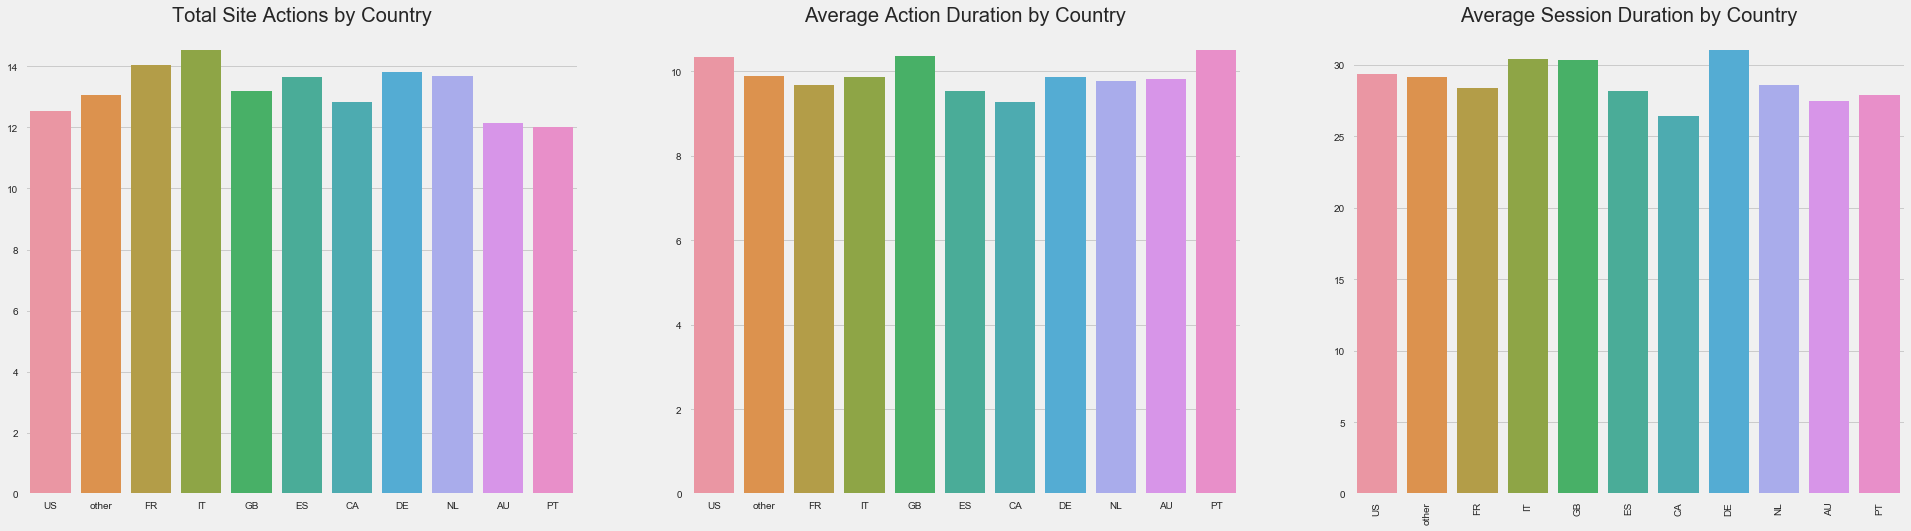

In [336]:
fig, axes = plt.subplots(1, 3,figsize=(30, 8))

countries = ucb.country_destination.value_counts().index.tolist()

def getAvg(country, feature):
    return ucb.loc[ucb['country_destination'] == country][feature].mean()

tot_act = [getAvg(country, 'actions_total_count') for country in countries]
avg_action_dur = [getAvg(country, 'average_action_duration') for country in countries]
avg_session_dur = [getAvg(country, 'sessions_total_duration') for country in countries]

bwsr = sns.barplot(countries, tot_act, ax=axes[0])
bwsr.set_title('Total Site Actions by Country')
# bwsr.set_ylim([0, .4])
plt.xticks(rotation=90)

bwsr = sns.barplot(countries, avg_action_dur, ax=axes[1])
bwsr.set_title('Average Action Duration by Country')
# bwsr.set_ylim([0, .4])
plt.xticks(rotation=90)

bwsr = sns.barplot(countries, avg_session_dur, ax=axes[2])
bwsr.set_title('Average Session Duration by Country')
# bwsr.set_ylim([0, .4])
plt.xticks(rotation=90)

plt.show()

By looking at the session data, we can see the variance in the average session time, average action time, and average total actions by country. These actions are things like viewing one's profile, searching through room listings, editing one's profile, etc. We can see that for the average session duration, there is a difference of 5 minutes between the countries with the largest, and shortest duration. The biggest difference for the average action duration between countries is only a minute, and the total actions range between 12, and 14.5. Could the difference in session time really play a role in what country someone might visit ? Perhaps someone who is more decisive, and spends less time on the site will go to a non european country, because someone going to europe might have to decide between a lot more options than the ones in North America.

## <p id="summary">Summary</p>

Based on our exploration of the data, there is certainly something we can say about the features of a user, and the destination chosen. Over time more and more AirBnB users are coming to the United States more than any other country. In the future, this finding could be made better if there was a feature to show where the user is from. For example people in european countries usually don't take big trips to neighboring countries, since they are so close together, and accessible by modes of transportation like the Eurail. Americans however will take large trip/vacations to other states e.g. Going from Arizona to visit New York, or going from Michigan to Florida for spring break. From the other time series showing age and gender over time, we can make a few conclusions. By looking at the average age per user for each country, we can see that for the United States, and the Netherlands, they are starting to attract younger users, and that the average age in general for visitors to Australia is noteably higher than other countries. In regards to the total number of men vs women booking trips over time for each country, they grow or fall about equally with each other except for Italy, and France, where the the number of males is leveling off, but female visitors continue to grow. Perhaps this is due to Italy and France having a romantic air to its charm that women are attracted to. For Australia, it is just the opposite though as the number of females visiting the country seems to be dropping sharply, whereas the amount of men booking trips there is continuing to grow. Countries in Oceania, like Australia, New Zealand, and Tasmania have more extreme elements to it like living conditions, and extreme sports such as bungee jumping, and rugby that may attract males more than females. When visiting AirBnB, you don't only have to option to book a stay with someone, but you can also purchase tickets to various events, and "experiences". This data was made available in 2013, so this might have only been created in the last 4 years, but having session data to show the amount of time they click on a particular category of event would really help analyze this futher. Users will usually book their first trip no more than 2 months after they create their account, and users are far less likely to book trips anytime in the winter. This can be made clearer by looking at the USA, and Australia. The number of visitors to Australia is more distributed in the months of November through February than any other country. This is most likely due to it being in the southern hemisphere where their seasons are inverted. The USA is very large and geographically located where it enjoys a diverse number of climates (Warm and humid in the south east, warm and dry in the southwest, and cold and dry in the northern Midwest, and cold and humid in the northeast, and northwest), and this may be the reason it has a flatter, more equal distribution compared to other countries farther north, and closer together in Europe. We found that there was something to say about the age of a user, and where they went to. A dense chunk of Spain's average visitors were young, and for Great Britian it was much older. The could be because of the intentions of certain age groups when the travel, adventure when you're young, and relaxation when you're older. Language was a big connection between the user and destination. The number of users who went to a country whose native tongue matched their language preference was over 70%.